# Label Chinese Stock Message Board Post Sentiment with Tensorflow - V1

**Dependencies**  
numpy  
jieba  
gensim  
tensorflow  
matplotlib  

In [1]:
# Load dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # for Chinese tokenization
# gensim for loading pre-trained word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
# for decompression
import bz2

**Source of Pretrained Word Embedding**  
https://github.com/Embedding/Chinese-Word-Vectors  
Finance news domain-specific word embedding 

In [2]:
# # the bz2 file should be in the directory named embeddings
# with open("embeddings/sgns.  .bigram", 'wb') as new_file, open("embeddings/sgns.  .bigram.bz2", 'rb') as file:
#     decompressor = bz2.BZ2Decompressor()
#     for data in iter(lambda : file.read(100 * 1024), b''):
#         new_file.write(decompressor.decompress(data))

In [3]:
# use gensim to load pre-trained embedding
cn_model = KeyedVectors.load_word2vec_format('embeddings/sgns.financial.bigram-char', 
                                             binary=False, unicode_errors="ignore")

In [4]:
embedding_dim = cn_model['慢'].shape[0]
print('The length of word embedding is {}.'.format(embedding_dim))
# cn_model['慢']

The length of word embedding is 300.


In [5]:
# Cosine Similarity for Vector Space Models by Christian S. Perone
# http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/
# similarity of two words
# cn_model.similarity('做空', '买')
# np.dot(cn_model['反弹']/np.linalg.norm(cn_model['反弹']), 
# cn_model['涨']/np.linalg.norm(cn_model['涨']))

In [6]:
# find most similar words to a keyword
cn_model.most_similar(positive=['大跌'], topn=10)

[('暴跌', 0.7939429879188538),
 ('重挫', 0.7413685321807861),
 ('下挫', 0.7085591554641724),
 ('下跌', 0.704810619354248),
 ('急跌', 0.7006838321685791),
 ('跳水', 0.658748984336853),
 ('挫', 0.6519291996955872),
 ('跌', 0.6498780250549316),
 ('暴涨', 0.6183834075927734),
 ('涨', 0.6176421642303467)]

In [7]:
# find word that doesn't belong to the category in a list
test_words = '反弹 大跌 下探 下挫 暴跌 亏损'
test_words_result = cn_model.doesnt_match(test_words.split())
print('Among '+test_words+':\n%s is different from others.' %test_words_result)

Among 反弹 大跌 下探 下挫 暴跌 亏损:
亏损 is different from others.


In [8]:
# concept pairing 
cn_model.most_similar(positive=['韭菜','买入'], negative=['庄家'], topn=1)

[('强烈推荐', 0.419800341129303)]

**Load the hand-labeled stock message board data**

In [9]:
sentiment_data_1 = pd.read_csv('sentiment_data_1.csv')
sentiment_data_1.sentiment = sentiment_data_1.sentiment.apply(int)
sentiment_data_1.sentiment = sentiment_data_1.sentiment.apply(lambda x: x if x>0 else 0)

In [10]:
sentiment_data_1 = sentiment_data_1.sample(frac=1).reset_index(drop=True)

In [11]:
min(sentiment_data_1['sentiment'].value_counts())

3727

In [12]:
dataset = sentiment_data_1[sentiment_data_1['sentiment']==1][:3720].append(sentiment_data_1[sentiment_data_1['sentiment']==0][:3720], ignore_index = True)

In [13]:
# dataset = dataset.sample(frac=1).reset_index(drop=True)

In [14]:
dataset['title_body'] = dataset['post_title'] + dataset['post_body']

In [15]:
print(len(dataset))

7440


In [16]:
train_texts_orig = dataset['title_body'].to_list()
train_target = dataset['sentiment'].to_list()

In [17]:
# importing tensorflow APIs
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

**Word cut and tokenization**  
Remove punctuation, use jieba to cut words, turn resulting generator into list, index the words according to loaded pre-trained embeddings. In the end, each post will be turned into a list of indices, with each index corresponding to the word in the embedding matrix. The indice-list represenation of posts are stored in train_tokens.

In [18]:
# Use jieba to parse and tokenize texts
train_tokens = []
for text in train_texts_orig:
    # remove punctuations
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # cut Chinese words with jieba
    cut = jieba.cut(text)
    # the outcome of jieba is a generator, the line below turns it into a list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # turn word into index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # if word not in dictionary, use 0
            cut_list[i] = 0
    train_tokens.append(cut_list)

Building prefix dict from /anaconda3/lib/python3.6/site-packages/jieba/dict.txt ...
Loading model from cache /var/folders/lv/brdmj4x916vdfmgkd6k2s_3r0000gn/T/jieba.cache
Loading model cost 0.9946861267089844 seconds.
Prefix dict has been built succesfully.


**Normalize Post Index-list**  
Posts vary in length. To save computational power and make sure all posts can be coded in the same shape.

In [19]:
# get the length of all posts
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

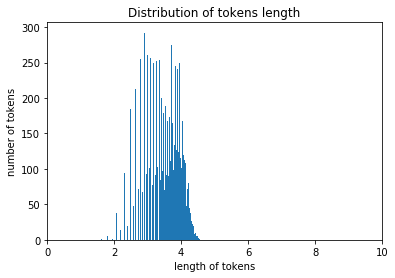

In [20]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [21]:
# Assuming the length follows Guassian distribution...
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

68

In [22]:
# We can cover 95% of the posts using 68, thus we can pad the short ones and truncate the long ones
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.964516129032258

**Reverse-tokenization**  
Define a function to map index to readable text, for debugging purpose

In [23]:
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [24]:
reverse = reverse_tokens(train_tokens[0])

In [25]:
# # However, punctuations are not retrieved.
# reverse

In [26]:
# # Comparing to original text
# train_texts_orig[0]

**Prepare Embedding Matrix**  
Keras needs a matrix with dimension $(numwords, embeddingdim)$
To save computational power, use the embeddings of only first 100000 words.

In [27]:
embedding_dim

300

In [28]:
num_words = 100000
# initialize embedding_matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [29]:
# check dimension and value of embedding are correct
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [30]:
embedding_matrix.shape

(100000, 300)

**Padding and truncating**  
Using 'pre' padding because some empirical studies suggest this practice.

In [31]:
# pad_sequences returns a numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [32]:
# words not in the first 100000 are represented as 0
train_pad[ train_pad>=num_words ] = 0

In [33]:
# example
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,   303, 14618,
        1413,   303, 14618,  1413,   303, 14618,  1413,   776, 19364,
        9352, 82709,     0,   634,  1553, 24506,   104,     0, 22744,
         125,   112,   303, 14618,  1413,   303, 14618,  1413,   303,
       14618,  1413,   776, 19364,  9352, 82709,     0,   634,  1553,
       24506,   104,     0, 22744,   125,   190,     0, 22744,    28,
       34824,  8371,     0,  8562,   907,   448,   669,     0,   849,
           0,  2129,   809,     0,  1467], dtype=int32)

In [34]:
# prepare target vector，first half are 1 (positive) second half are 0 (negative)
train_target = np.array(train_target)

In [35]:
# train_target[len(train_target)//2:]

**Train test split**

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
# 90% as training，10% as testing
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.2,
                                                    random_state=101)

In [38]:
# checking training set 
print('text: ',reverse_tokens(X_train[35]).strip())
print('class: ',y_train[35])

text:  上证指数3500左右震荡有望再 下走3450周一抄底周二周三   上证指数3500左右震荡有望再 下走3450周一抄底周二周三 多观望周四 短线获利落袋为安周四尾盘或周五注意风险
class:  0


**Start building model**

In [39]:
model = Sequential()

Embedding layer input: $$(batchsize, maxtokens)$$
Embedding layer ouput: $$(batchsize, maxtokens, embeddingdim)$$

In [40]:
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

In [41]:
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=True))

In [42]:
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=4, return_sequences=False))

In [43]:
model.add(Dense(1, activation='sigmoid'))
# optimizer = Adam(lr=1e-3)

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
# structure of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 300)           30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 68, 128)           186880    
_________________________________________________________________
lstm_1 (LSTM)                (None, 68, 16)            9280      
_________________________________________________________________
gru (GRU)                    (None, 68, 32)            4704      
_________________________________________________________________
gru_1 (GRU)                  (None, 68, 16)            2352      
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 252       
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [46]:
# weighting storage
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [47]:
# try_loading_pretrained_model
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = 'sentiment_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [48]:
# Define early stoping if validation loss doesn't improve in 3 epochs
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [49]:
# decreasing learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [50]:
# callback functions
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [51]:
# start fitting
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 5356 samples, validate on 596 samples
Epoch 1/20
5248/5356 [============================>.] - ETA: 1s - loss: 0.5462 - accuracy: 0.7222
Epoch 00001: val_loss improved from inf to 0.40407, saving model to sentiment_checkpoint.keras
5356/5356 [==============================] - 58s 11ms/sample - loss: 0.5427 - accuracy: 0.7248 - val_loss: 0.4041 - val_accuracy: 0.8289
Epoch 2/20
5248/5356 [============================>.] - ETA: 0s - loss: 0.3975 - accuracy: 0.8357
Epoch 00002: val_loss improved from 0.40407 to 0.36268, saving model to sentiment_checkpoint.keras
5356/5356 [==============================] - 36s 7ms/sample - loss: 0.3980 - accuracy: 0.8355 - val_loss: 0.3627 - val_accuracy: 0.8557
Epoch 3/20
5248/5356 [============================>.] - ETA: 0s - loss: 0.3481 - accuracy: 0.8639
Epoch 00003: val_loss improved from 0.36268 to 0.34075, saving model to sentiment_checkpoint.keras
5356/5356 [==============================] - 33s 6ms/sample - loss: 0.3475 - accuracy: 0.8639

**Evaluate with test set**

In [52]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

1488/1488 [==============================] - 3s 2ms/sample - loss: 0.3508 - accuracy: 0.8542
Accuracy:85.42%


In [53]:
def predict_sentiment(text):
    print(text)
    # remove punctuations
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # cut words
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # prediction
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('postive','output=%.2f'%coef)
    else:
        print('negative','output=%.2f'%coef)

In [60]:
test_list = [
    '无量上涨，冲高回落',
    '大盘已经跌到底了，散户们冲啊抄底',
    '为国护盘，坚定持有',
    '吧里的多头去哪里了呢',
    '这轮反弹即将结束，建议大家逢高撤出',
    '明显是庄家诱多，傻散才会抄底呢[傲]',
    '明天开盘大涨，打爆这些空头'
]
for text in test_list:
    predict_sentiment(text)

无量上涨，冲高回落
postive output=0.85
大盘已经跌到底了，散户们冲啊抄底
postive output=0.89
为国护盘，坚定持有
postive output=0.91
吧里的多头去哪里了呢
negative output=0.36
这轮反弹即将结束，建议大家逢高撤出
postive output=0.91
明显是庄家诱多，傻散才会抄底呢[傲]
postive output=0.93
明天开盘大涨，打爆这些空头
negative output=0.37


**Misclassified posts**<br>
The concept of '反弹' is not properly learned.

In [61]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [62]:
y_actual = np.array(y_test)

In [63]:
misclassified = np.where( y_pred != y_actual )[0]

In [64]:
print(len(misclassified),end='/')
print(len(X_test))

217/1488


In [65]:
# example of misclassified
idx = misclassified[2]
print(reverse_tokens(X_test[idx]).strip())
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

久违的逼空光头大阳盼来了久违的逼空光头大阳盼来了
预测的分类 1
实际的分类 0


In [66]:
# example of correcetly classified
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                       市场资金正在从高价股转向低价股关注600512腾达建设浙江板块工程建设板块市场资金正在从高价股转向低价股关注600512腾达建设浙江板块工程建设板块双料低价冠军后续订单 定向增发停牌重组可期股价528元
预测的分类 0
实际的分类 0


In [67]:
# References
# https://github.com/aespresso/chinese_sentiment